In [128]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

In [129]:
# Garantir reprodutibilidade total
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [130]:
df = pd.read_csv('data_per_month.csv')
df = df['Total Renewable Energy']

In [131]:
# Função para criar janelas de dados
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Função para remover outliers
def remove_outliers(X, y, threshold=3):
    mask_X = np.all(np.abs(X - np.mean(X, axis=0)) <= threshold * np.std(X, axis=0), axis=1)
    mask_y = np.abs(y - np.mean(y)) <= threshold * np.std(y)
    mask = mask_X & mask_y
    return X[mask], y[mask]

In [132]:
# Criar janelas de tamanho 12
window_size = 12
X, y = create_windows(df, window_size)

# Remover outliers
X_clean, y_clean = remove_outliers(X, y)

# Dividir em conjuntos de treino, validação e teste
train_size = int(len(X_clean) * 0.7)
val_size = int(len(X_clean) * 0.15)

X_train, y_train = X_clean[:train_size], y_clean[:train_size]
X_val, y_val = X_clean[train_size:train_size + val_size], y_clean[train_size:train_size + val_size]
X_test, y_test = X_clean[train_size + val_size:], y_clean[train_size + val_size:]

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [133]:
# Função para criar o modelo com regularização
def create_model_with_optimizer(neurons=8, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(neurons, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(neurons, activation='relu'),
        Dense(1)
    ])
    optimizer_instance = Adam() if optimizer == 'adam' else RMSprop()
    model.compile(optimizer=optimizer_instance, loss='mse', metrics=['mae'])
    return model

# Encapsular o modelo com KerasRegressor
model = KerasRegressor(model=create_model_with_optimizer, verbose=0)

# Definir o espaço de hiperparâmetros
param_grid = {
    'model__neurons': [8],
    'model__dropout_rate': [0.2],
    'batch_size': [16],
    'epochs': [100],
    'optimizer': ['adam', 'rmsprop']
}

# Configurar e executar o Grid Search com TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
grid_result = grid.fit(X_train_scaled, y_train)

# Resultados
print("Melhores hiperparâmetros:", grid_result.best_params_)
print("Melhor pontuação (MSE):", grid_result.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Melhores hiperparâmetros: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__neurons': 8, 'optimizer': 'rmsprop'}
Melhor pontuação (MSE): -53.324075978010725


In [134]:
# Fazer previsões no conjunto de teste
y_pred = grid.predict(X_test_scaled)

# Calcular métricas de avaliação
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
cosine_similarity = np.dot(y_test, y_pred) / (np.linalg.norm(y_test) * np.linalg.norm(y_pred))
std_deviation = np.std(y_test - y_pred)

In [135]:
# Plotar curva de aprendizado
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

history = grid.best_estimator_.model_.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=grid_result.best_params_['epochs'],
    batch_size=grid_result.best_params_['batch_size'],
    callbacks=[early_stopping],
    verbose=0
)


--- Relatório Final ---
Melhores hiperparâmetros: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__neurons': 8, 'optimizer': 'rmsprop'}
Melhor pontuação (MSE): -53.3241
R²: 0.2308
RMSE: 28.0221
MAPE: 4.42%
Similaridade de Cosseno: 0.9986
Desvio Padrão entre Real e Preditos: 27.2085


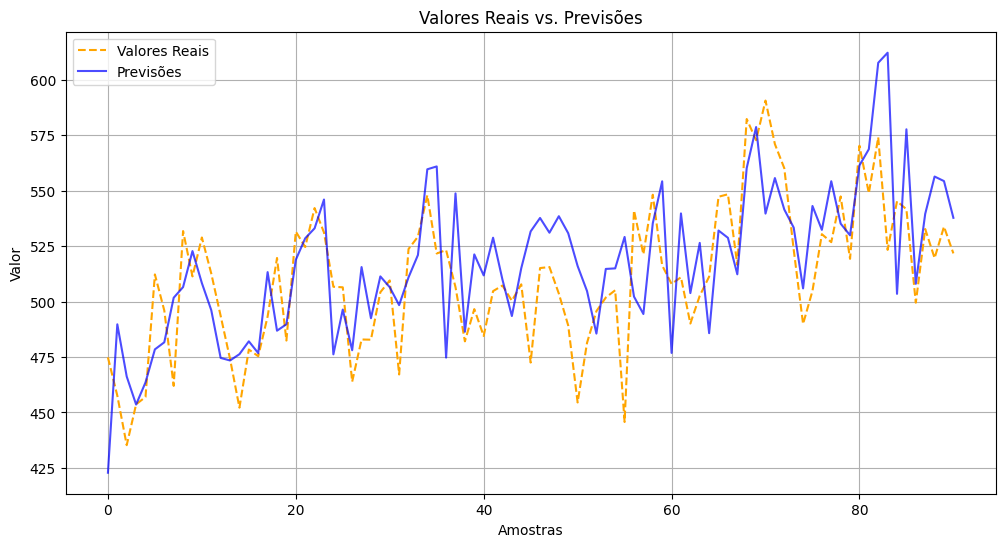

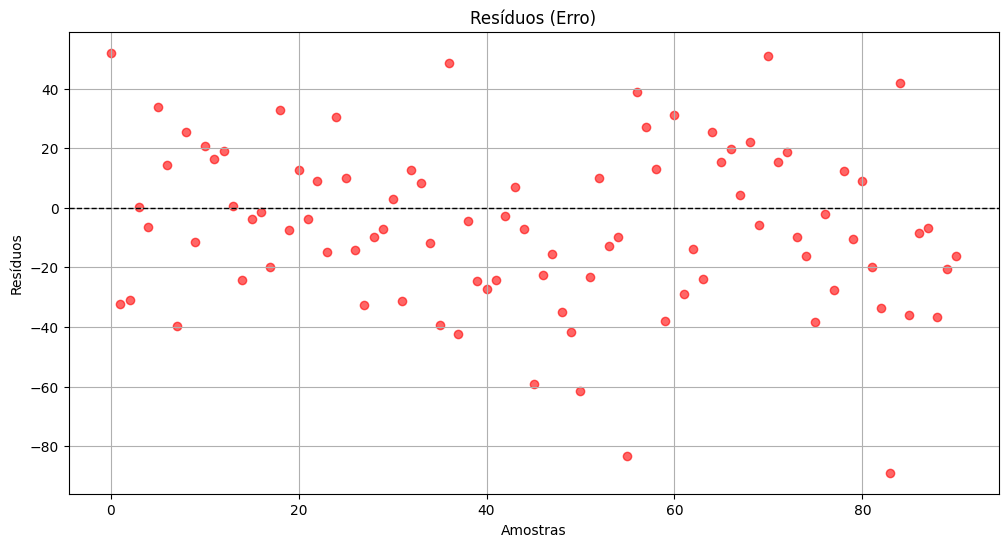

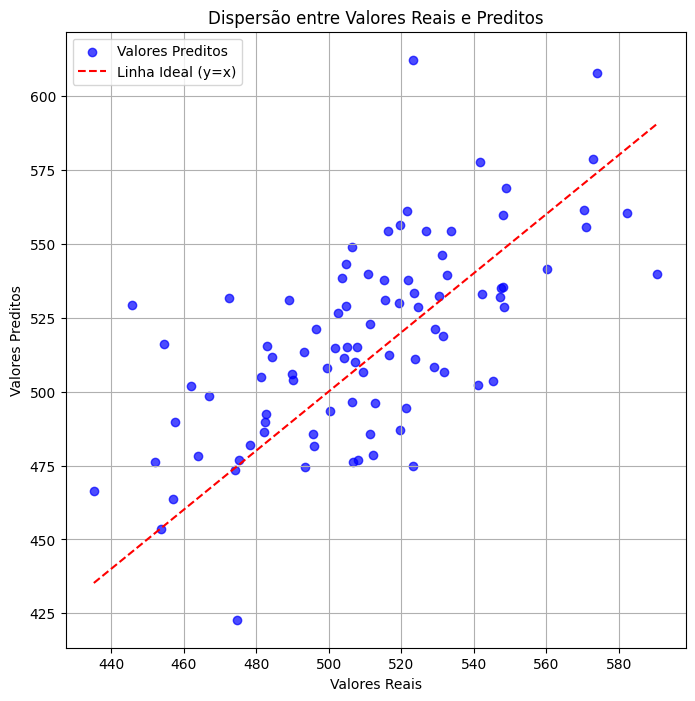

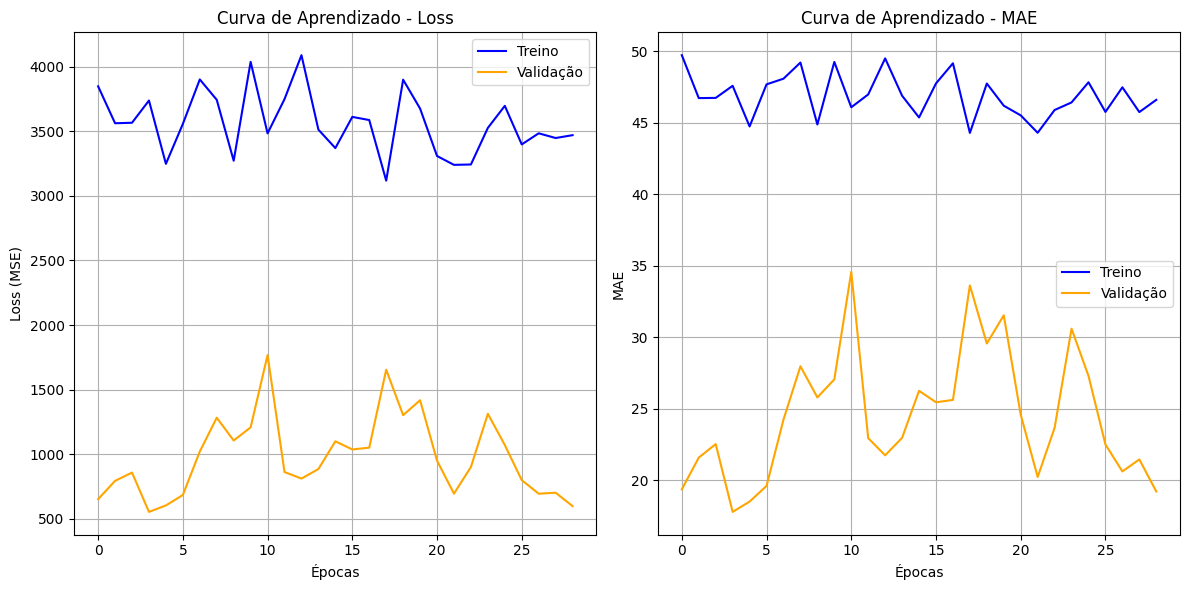

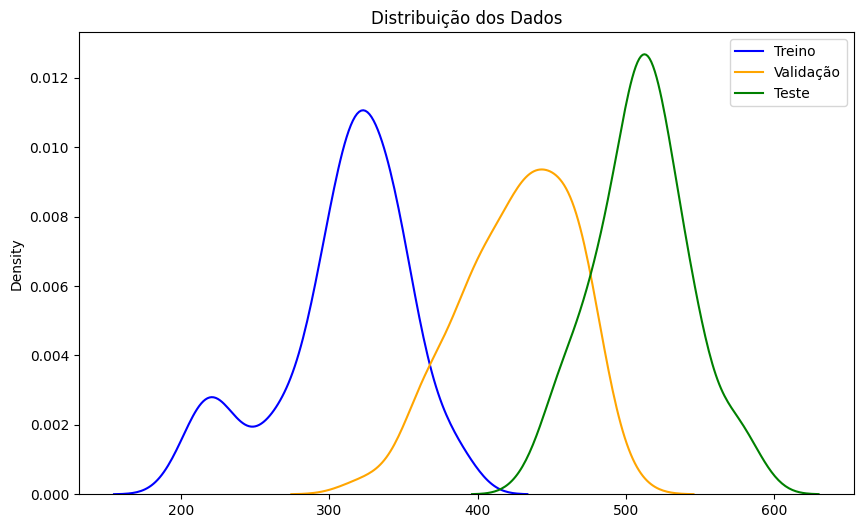

In [136]:
# Relatório final
print("\n--- Relatório Final ---")
print(f"Melhores hiperparâmetros: {grid_result.best_params_}")
print(f"Melhor pontuação (MSE): {grid_result.best_score_:.4f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Similaridade de Cosseno: {cosine_similarity:.4f}")
print(f"Desvio Padrão entre Real e Preditos: {std_deviation:.4f}")

# Plotar valores reais vs. preditos
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Valores Reais", color='orange', linestyle='--')
plt.plot(y_pred, label="Previsões", color='blue', alpha=0.7)
plt.xlabel("Amostras")
plt.ylabel("Valor")
plt.title("Valores Reais vs. Previsões")
plt.legend()
plt.grid()
plt.show()

# Plotar resíduos
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Amostras")
plt.ylabel("Resíduos")
plt.title("Resíduos (Erro)")
plt.grid()
plt.show()

# Gráfico de dispersão entre valores reais e preditos
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label="Valores Preditos")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Linha Ideal (y=x)")
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Dispersão entre Valores Reais e Preditos")
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino', color='blue')
plt.plot(history.history['val_loss'], label='Validação', color='orange')
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.title("Curva de Aprendizado - Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Treino', color='blue')
plt.plot(history.history['val_mae'], label='Validação', color='orange')
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.title("Curva de Aprendizado - MAE")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(y_train, label="Treino", color="blue")
sns.kdeplot(y_val, label="Validação", color="orange")
sns.kdeplot(y_test, label="Teste", color="green")
plt.title("Distribuição dos Dados")
plt.legend()
plt.show()